<a href="https://colab.research.google.com/github/fransiscaanggr/Tugas-Besar-Dasar-Kecerdasan-Artifisial/blob/main/TUBES_DKA_PREDIKSI_HUJAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  
<div style="background-color:#f0f8ff; padding: 20px; border-radius: 10px; border: 1px solid #ccc;">
    <h1 style="text-align: center; color: #2e6c80; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
        🌧️ Prediksi Hujan dengan Fuzzy System ☁️
    </h1>
    <hr style="border: 1px solid #ccc;">
    <p style="text-align: center; font-size: 18px; color: #333;">
        Notebook ini menggunakan pendekatan <strong>Fuzzy Logic</strong> untuk memprediksi kemungkinan terjadinya hujan berdasarkan data cuaca.
    </p>
</div>

<div>
    <h3 style="color: #2e6c80;">📘 Dasar Kecerdasan Artifisial</h3>
    <p><strong>Kelas:</strong> IF-47-12</p>
    <p><strong>Anggota Kelompok:</strong></p>
    <ul>
        <li>Fransisca Anggraeni Hartakaadi - <code>103012300366</code></li>
        <li>Nida Hijria Almany - <code>103012330169</code></li>
        <li>Salsabilla Najwa Khasanah - <code>103012300329</code></li>
    </ul>
</div>


### **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## **Preprocessing Data**

### 1. Load Dataset

In [ ]:
df = pd.read_csv('usa_rain_prediction_dataset_2024_2025.csv')
print("\n📌 Total Data Awal:", df.dropna().shape[0], "data")

rain_tomorrow_1 = df[df['Rain Tomorrow'] == 1].sample(n=500, random_state=42)
rain_tomorrow_0 = df[df['Rain Tomorrow'] == 0].sample(n=500, random_state=42)
sample = pd.concat([rain_tomorrow_1, rain_tomorrow_0])

sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n📌 Diambil 1000 Data Sampel yang sudah diseimbangkan berdasarkan nilai output (Rain Tomorrow):")
print("    500 data ( Rain Tomorrow = 1)")
print("    500 data (Rain Tomorrow = 0)\n")

print("\n📌 Tampilan dataset sampel:")
print(sample.head(10))


📌 Total Data Awal: 73100 data

📌 Diambil 1000 Data Sampel yang sudah diseimbangkan berdasarkan nilai output (Rain Tomorrow):
    500 data ( Rain Tomorrow = 1)
    500 data (Rain Tomorrow = 0)


📌 Tampilan dataset sampel:
         Date       Location  Temperature   Humidity  Wind Speed  \
0  2024-01-04   Indianapolis    36.013031  39.905446   18.347730   
1  2025-05-10         Austin    73.260144  91.443422   12.758588   
2  2025-05-09     Fort Worth    77.011921  56.100997    0.171484   
3  2024-08-23   Indianapolis    86.444189  49.999738   18.102066   
4  2025-03-14      San Diego    85.886436  97.131528   14.416041   
5  2025-03-12    Los Angeles    63.276223  49.708375   11.302368   
6  2025-04-29     Fort Worth    95.481925  79.420300   11.155018   
7  2024-05-24         Austin    79.068532  94.465994    0.588342   
8  2024-05-27      San Diego    58.863999  48.308538   21.399738   
9  2025-10-20  San Francisco    46.813270  88.272097   11.393693   

   Precipitation  Cloud Cover


📌 Distribusi Target (Besok Hujan):
Rain Tomorrow
0    0.5
1    0.5
Name: proportion, dtype: float64
Date             1000
Location         1000
Temperature      1000
Humidity         1000
Wind Speed       1000
Precipitation    1000
Cloud Cover      1000
Pressure         1000
Rain Tomorrow    1000
dtype: int64


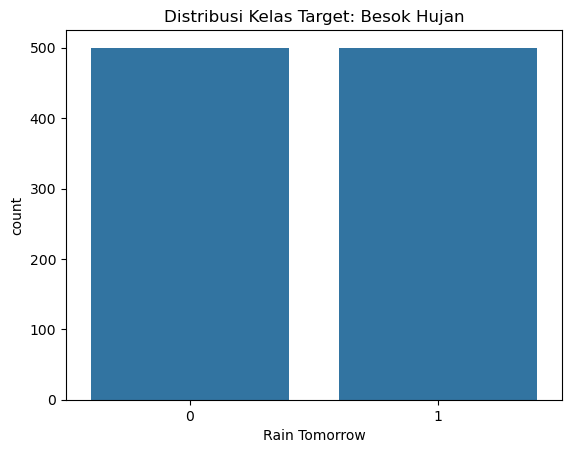

In [ ]:
# --- Cek Imbalance Target ---
print("\n📌 Distribusi Target (Besok Hujan):")
print(sample['Rain Tomorrow'].value_counts(normalize=True))

print(sample.count())
sns.countplot(x='Rain Tomorrow', data=sample)
plt.title('Distribusi Kelas Target: Besok Hujan')
plt.show()

### 2. Data Understanding (Rename Kolom/Parameter)

In [ ]:
# Rename kolom untuk mempermudah understanding data
sample = sample.rename(columns={
    'Date' : 'Tanggal',
    'Location' : 'Lokasi',
    'Temperature' : 'Suhu', # Fahrenheit (°F)
    'Humidity': 'Kelembaban', # Persentase (%)
    'Wind Speed': 'Kecepatan Angin', # Kilometer per jam (km/h)
    'Precipitation': 'Curah Hujan', # 	Milimeter (mm)
    'Cloud Cover': 'Tutupan Awan', # Persentase (%)
    'Pressure': 'Tekanan', # Hektopascal (hPa)
    'Rain Tomorrow': 'Besok Hujan' # Kategori biner (1 = Ya, 0 = Tidak)
})
print("\n📌 Dataset Setelah Di-rename:")
display(sample.head(5))


📌 Dataset Setelah Di-rename:


,Tanggal,Lokasi,Suhu,Kelembaban,Kecepatan Angin,Curah Hujan,Tutupan Awan,Tekanan,Besok Hujan
0,2024-01-04,Indianapolis,36.013031,39.905446,18.347730,0.000000,56.602176,1023.096861,0
1,2025-05-10,Austin,73.260144,91.443422,12.758588,0.000000,30.210518,1029.123386,0
2,2025-05-09,Fort Worth,77.011921,56.100997,0.171484,0.333589,15.681176,976.265971,0
3,2024-08-23,Indianapolis,86.444189,49.999738,18.102066,0.000000,60.943978,1008.216038,0
4,2025-03-14,San Diego,85.886436,97.131528,14.416041,0.850080,83.893885,993.415502,1


### 3. Cek Struktur dan Missing Value


📌 Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Tanggal          1000 non-null   object 
 1   Lokasi           1000 non-null   object 
 2   Suhu             1000 non-null   float64
 3   Kelembaban       1000 non-null   float64
 4   Kecepatan Angin  1000 non-null   float64
 5   Curah Hujan      1000 non-null   float64
 6   Tutupan Awan     1000 non-null   float64
 7   Tekanan          1000 non-null   float64
 8   Besok Hujan      1000 non-null   int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 70.4+ KB
None

📌 Jumlah Missing Value per Kolom:
Tanggal            0
Lokasi             0
Suhu               0
Kelembaban         0
Kecepatan Angin    0
Curah Hujan        0
Tutupan Awan       0
Tekanan            0
Besok Hujan        0
dtype: int64


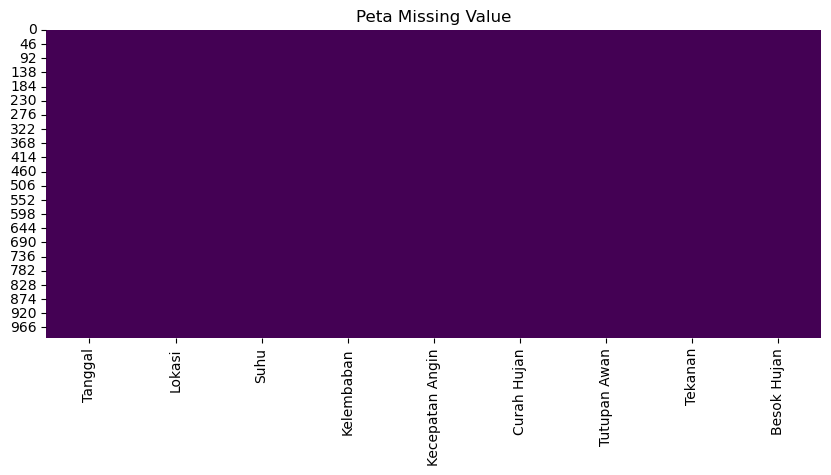

In [ ]:
# === Cek Struktur dan Missing Value ===
print("\n📌 Info Dataset:")
print(sample.info())

print("\n📌 Jumlah Missing Value per Kolom:")
print(sample.isnull().sum())

# Visualisasi missing value
plt.figure(figsize=(10, 4))
sns.heatmap(sample.isnull(), cbar=False, cmap='viridis')
plt.title("Peta Missing Value")
plt.show()

### 4. Exploratory Statistics (Cek Nilai Statistik)

In [ ]:
# ===  Statistik Deskriptif ===
print("\n📌 Statistik Deskriptif:")
display(sample.describe())


📌 Statistik Deskriptif:


,Suhu,Kelembaban,Kecepatan Angin,Curah Hujan,Tutupan Awan,Tekanan,Besok Hujan
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.219502,66.092361,14.693717,0.557676,55.131277,1005.965458,0.50000
std,19.560991,22.017021,8.553714,0.508599,26.178843,19.621536,0.50025
min,30.093634,20.154506,0.012571,0.000000,10.005920,970.046126,0.00000
25%,48.707829,49.481787,7.527710,0.000150,33.112173,989.008260,0.00000
50%,65.164660,69.452134,14.506380,0.485894,55.065516,1007.410129,0.50000
75%,81.864698,84.255809,21.852791,0.902093,78.656012,1022.803430,1.00000
max,99.960465,99.983086,29.996867,2.493731,99.985235,1039.921328,1.00000



📌 Histogram:


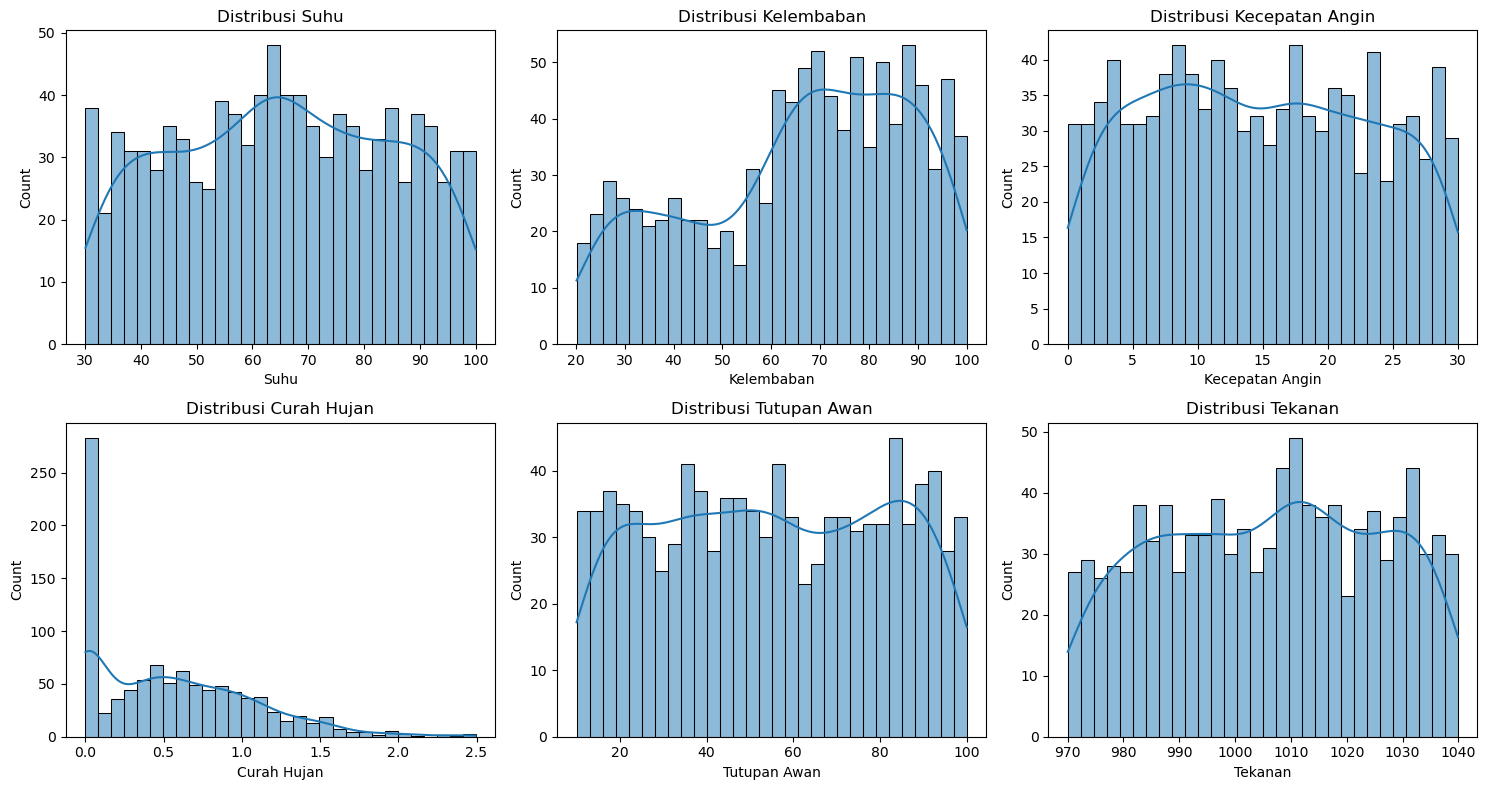


📌 Boxplot:


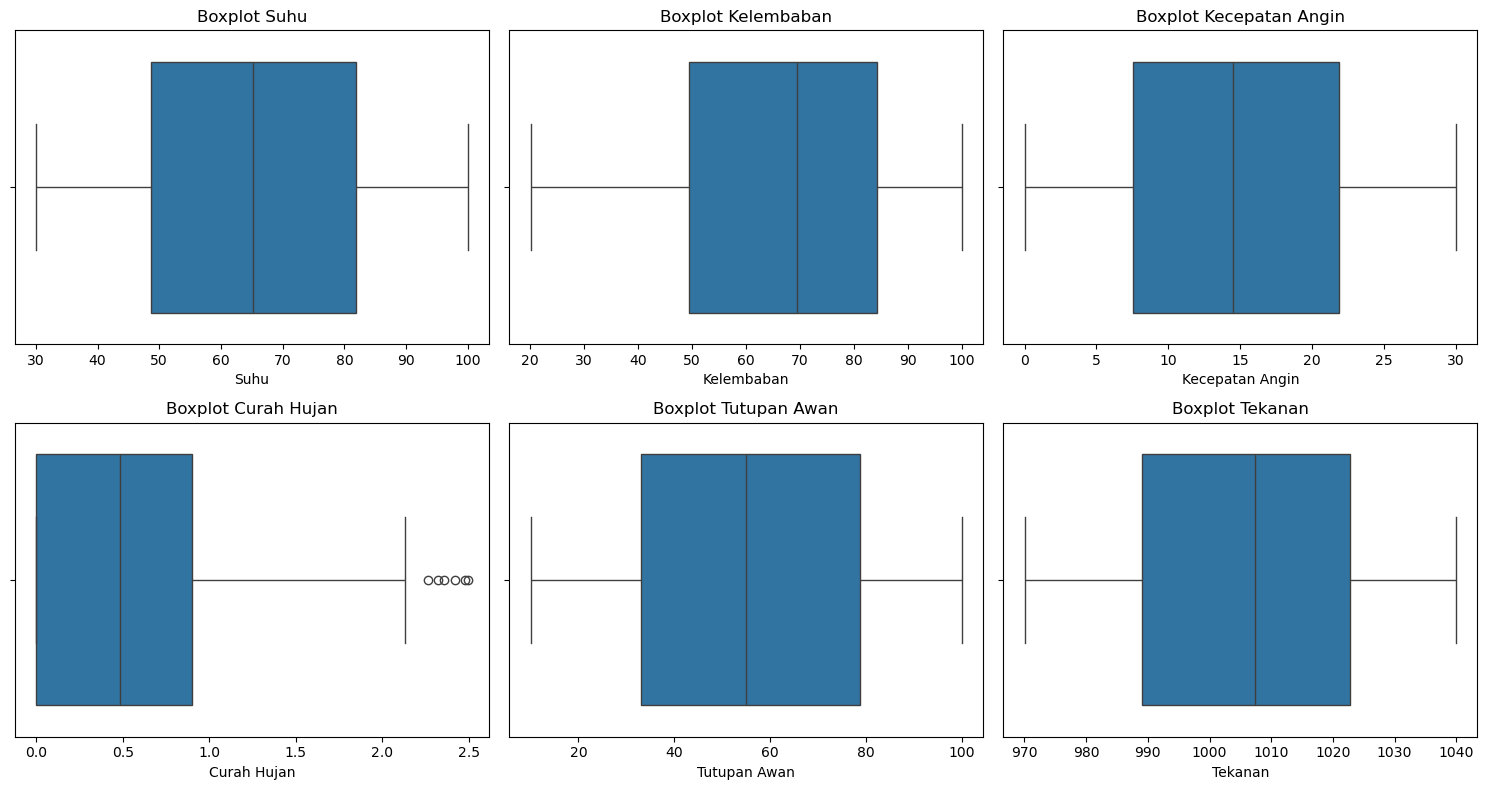


📌 Matriks Kolerasi:


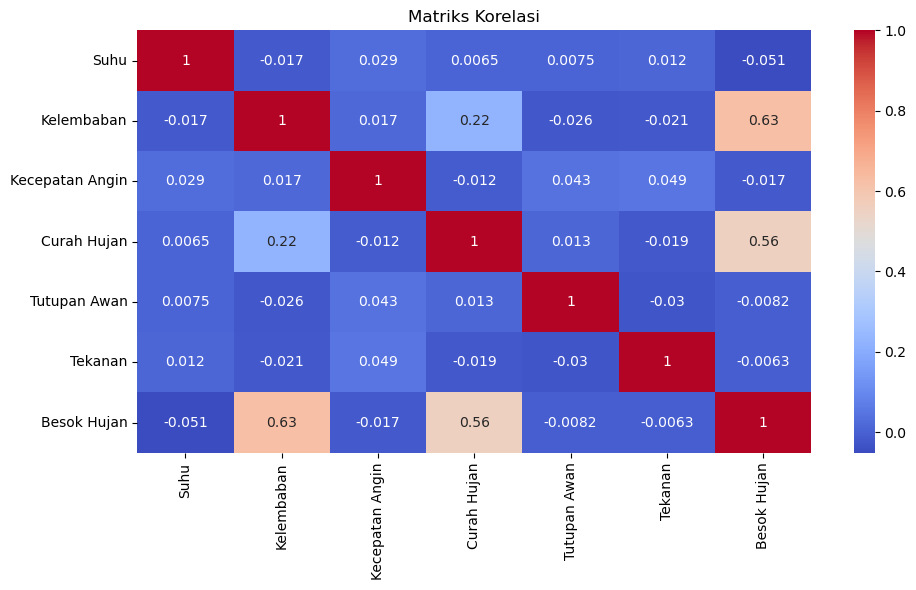

In [ ]:
# ===  Visualisasi Histogram (3 grafik per baris) ===
num_cols = ['Suhu', 'Kelembaban', 'Kecepatan Angin', 'Curah Hujan', 'Tutupan Awan', 'Tekanan']
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(sample[col], bins=30, kde=True)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
plt.tight_layout()
print("\n📌 Histogram:")
plt.show()

# === Boxplot Outlier Check ===
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=sample[col])
    plt.title(f'Boxplot {col}')
    plt.xlabel(col)
plt.tight_layout()
print("\n📌 Boxplot:")
plt.show()

# === Korelasi Fitur ===
plt.figure(figsize=(10, 6))
corr = sample[num_cols + ['Besok Hujan']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi')
plt.tight_layout()
print("\n📌 Matriks Kolerasi:")
plt.show()

## **Mengimplementasikan Fuzzy System**

### 1. Definisi Linguistik

| Variabel          | Nilai Linguistik                                      |
|-------------------|--------------------------------------------------------|
| Suhu              | Dingin, Normal, Panas                                 |
| Kelembaban        | Rendah, Normal, Tinggi                                |
| Kecepatan Angin   | Rendah, Sedang, Tinggi                                |
| Curah Hujan       | Rendah, Sedang, Tinggi                                |
| Tutupan Awan      | Sedikit, Sebagian, Mendung                            |
| Tekanan           | Rendah, Normal, Tinggi                                |
| Kemungkinan Hujan | Rendah, Sedang, Tinggi                                |



### 2. Fungsi Keanggotaan

✅ Fungsi keanggotaan telah didefinisikan


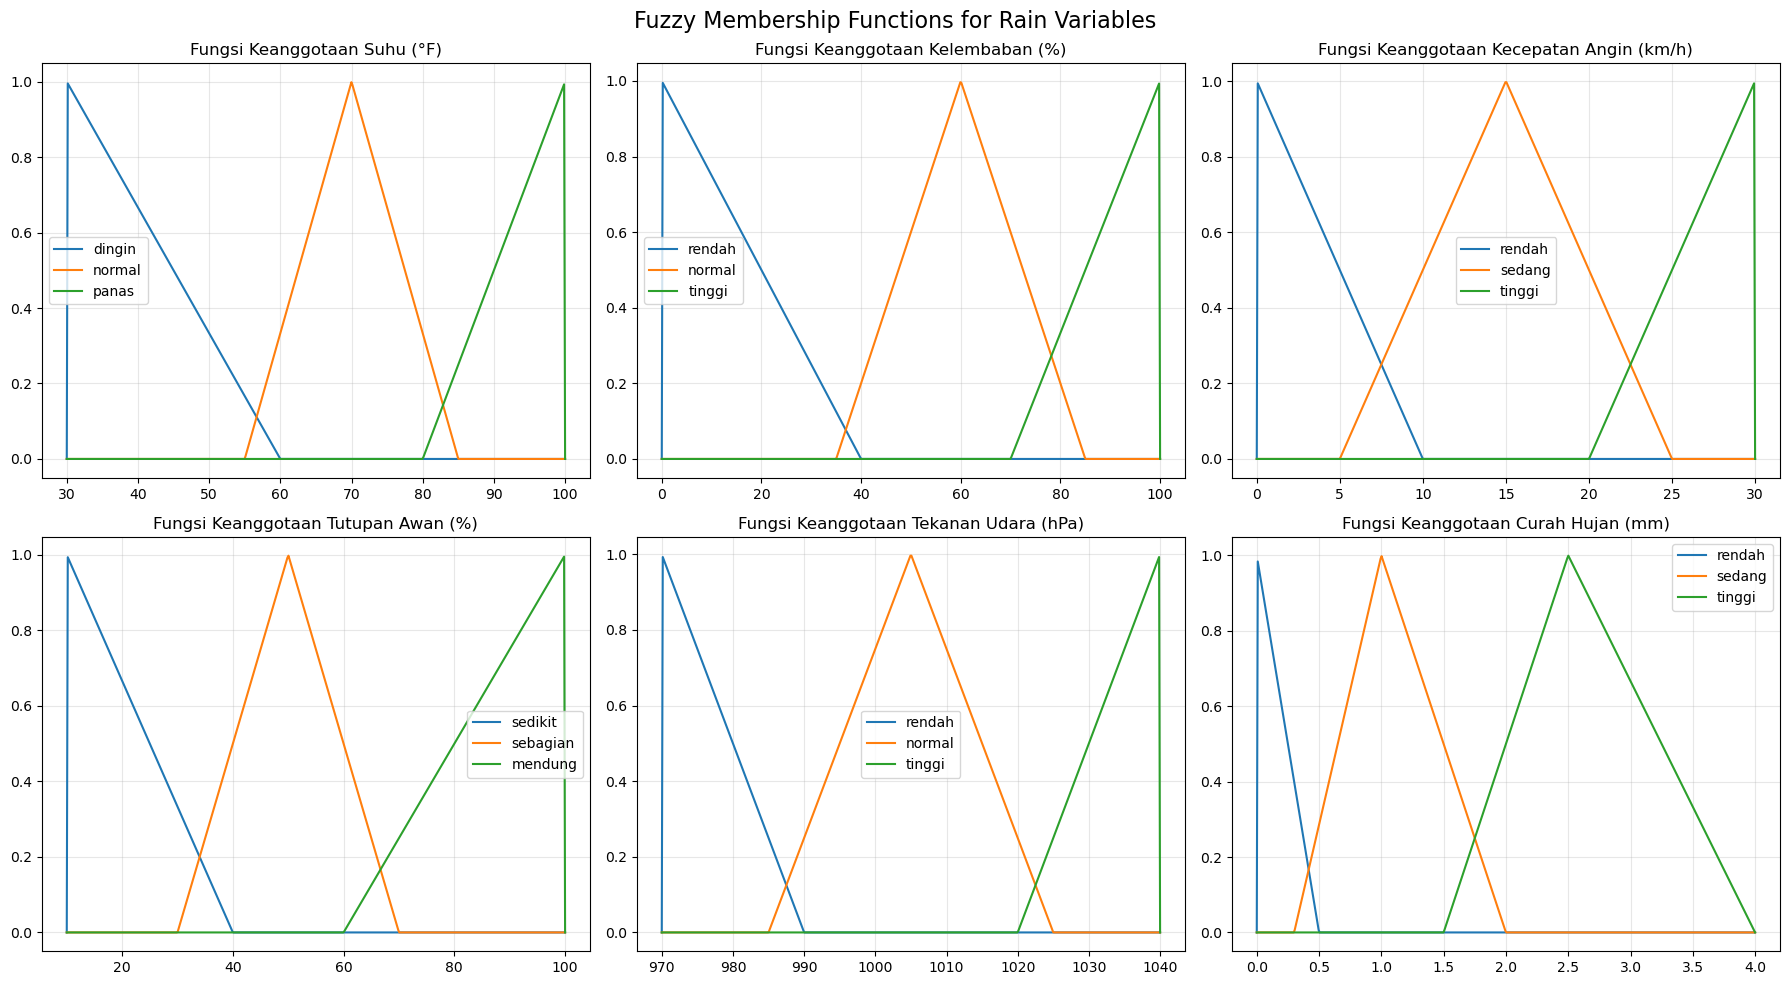

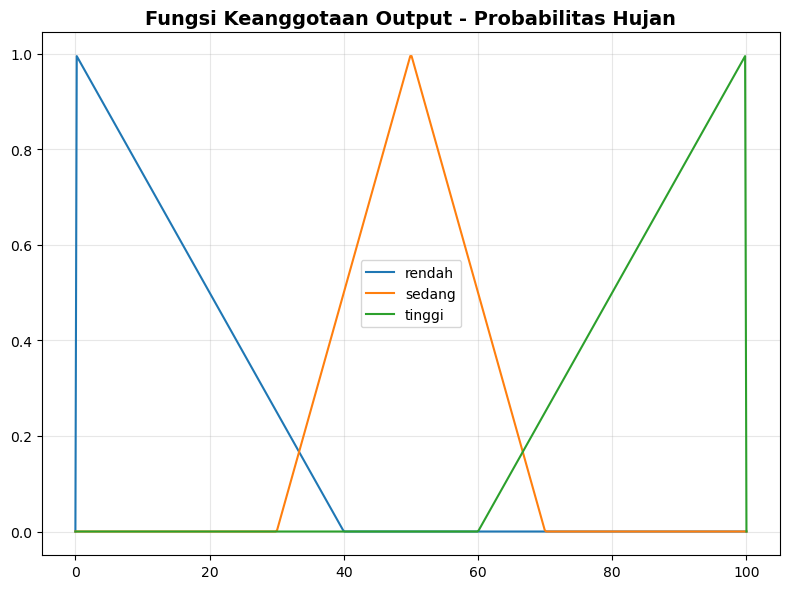

In [ ]:
# Fungsi segitiga (triangular membership function)
def trimf(x, a, b, c):
    """Triangular membership function"""
    return np.maximum(np.minimum((x - a) / (b - a + 1e-6), (c - x) / (c - b + 1e-6)), 0)

# ----------- 1. Suhu -----------
x_temp = np.linspace(30, 100, 500)
suhu = {
    'dingin': trimf(x_temp, 30, 30, 60),
    'normal': trimf(x_temp, 55, 70, 85),
    'panas':  trimf(x_temp, 80, 100, 100)
}

# ----------- 2. Kelembaban -----------
x_hum = np.linspace(0, 100, 500)
kelembaban = {
    'rendah': trimf(x_hum, 0, 0, 40),
    'normal': trimf(x_hum, 35, 60, 85),
    'tinggi': trimf(x_hum, 70, 100, 100)
}

# ----------- 3. Kecepatan Angin -----------
x_wind = np.linspace(0, 30, 500)
angin = {
    'rendah': trimf(x_wind, 0, 0, 10),
    'sedang': trimf(x_wind, 5, 15, 25),
    'tinggi': trimf(x_wind, 20, 30, 30)
}

# ----------- 4. Curah Hujan -----------
x_rain = np.linspace(0, 4, 500)
curah_hujan = {
    'rendah': trimf(x_rain, 0, 0, 0.5),
    'sedang': trimf(x_rain, 0.3, 1.0, 2.0),
    'tinggi': trimf(x_rain, 1.5, 2.5, 4.0)
}

# ----------- 5. Tutupan Awan -----------
x_cloud = np.linspace(10, 100, 500)
awan = {
    'sedikit': trimf(x_cloud, 10, 10, 40),
    'sebagian': trimf(x_cloud, 30, 50, 70),
    'mendung': trimf(x_cloud, 60, 100, 100)
}

# ----------- 6. Tekanan Udara -----------
x_press = np.linspace(970, 1040, 500)
tekanan = {
    'rendah': trimf(x_press, 970, 970, 990),
    'normal': trimf(x_press, 985, 1005, 1025),
    'tinggi': trimf(x_press, 1020, 1040, 1040)
}

# ----------- 7. Output - Probabilitas Hujan -----------
x_output = np.linspace(0, 100, 500)
hujan_output = {
    'rendah': trimf(x_output, 0, 0, 40),
    'sedang': trimf(x_output, 30, 50, 70),
    'tinggi': trimf(x_output, 60, 100, 100)
}

print("✅ Fungsi keanggotaan telah didefinisikan")

# Visualisasi fungsi keanggotaan
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Fuzzy Membership Functions for Rain Variables', fontsize=16)

# Suhu
for label, mf in suhu.items():
    axs[0, 0].plot(x_temp, mf, label=label)
axs[0, 0].set_title('Fungsi Keanggotaan Suhu (°F)')
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# Kelembaban
for label, mf in kelembaban.items():
    axs[0, 1].plot(x_hum, mf, label=label)
axs[0, 1].set_title('Fungsi Keanggotaan Kelembaban (%)')
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# Kecepatan Angin
for label, mf in angin.items():
    axs[0, 2].plot(x_wind, mf, label=label)
axs[0, 2].set_title('Fungsi Keanggotaan Kecepatan Angin (km/h)')
axs[0, 2].legend()
axs[0, 2].grid(True, alpha=0.3)

# Tutupan Awan
for label, mf in awan.items():
    axs[1, 0].plot(x_cloud, mf, label=label)
axs[1, 0].set_title('Fungsi Keanggotaan Tutupan Awan (%)')
axs[1, 0].legend()
axs[1, 0].grid(True, alpha=0.3)

# Tekanan Udara
for label, mf in tekanan.items():
    axs[1, 1].plot(x_press, mf, label=label)
axs[1, 1].set_title('Fungsi Keanggotaan Tekanan Udara (hPa)')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

# Curah Hujan
for label, mf in curah_hujan.items():
    axs[1, 2].plot(x_rain, mf, label=label)
axs[1, 2].set_title('Fungsi Keanggotaan Curah Hujan (mm)')
axs[1, 2].legend()
axs[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tampilkan juga output
fig, ax = plt.subplots(figsize=(8, 6))
for label, mf in hujan_output.items():
    ax.plot(x_output, mf, label=label)
ax.set_title('Fungsi Keanggotaan Output - Probabilitas Hujan', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3. Definisi Variabel Input

In [ ]:
# Fuzzifikasi nilai crisp menjadi derajat keanggotaan fuzzy
def fuzzify_value(value, universe, membership_functions):
    result = {}
    # Cari indeks terdekat di universe
    idx = np.abs(universe - value).argmin()

    # Hitung derajat keanggotaan untuk setiap fungsi keanggotaan
    for label, mf in membership_functions.items():
        result[label] = mf[idx]

    return result

# Fuzzifikasi semua input dari satu baris data
def fuzzify_input(data_row):
    # Pastikan nilai input dalam range yang valid
    suhu_val = max(30, min(100, data_row['Suhu']))
    kelembaban_val = max(0, min(100, data_row['Kelembaban']))
    angin_val = max(0, min(30, data_row['Kecepatan Angin']))
    hujan_val = max(0, min(4, data_row['Curah Hujan']))
    awan_val = max(10, min(100, data_row['Tutupan Awan']))
    tekanan_val = max(970, min(1040, data_row['Tekanan']))

    # Fuzzifikasi setiap input
    fuzzy_suhu = fuzzify_value(suhu_val, x_temp, suhu)
    fuzzy_kelembaban = fuzzify_value(kelembaban_val, x_hum, kelembaban)
    fuzzy_angin = fuzzify_value(angin_val, x_wind, angin)
    fuzzy_hujan = fuzzify_value(hujan_val, x_rain, curah_hujan)
    fuzzy_awan = fuzzify_value(awan_val, x_cloud, awan)
    fuzzy_tekanan = fuzzify_value(tekanan_val, x_press, tekanan)

    return {
        'suhu': fuzzy_suhu,
        'kelembaban': fuzzy_kelembaban,
        'angin': fuzzy_angin,
        'hujan': fuzzy_hujan,
        'awan': fuzzy_awan,
        'tekanan': fuzzy_tekanan
    }

### 4. Aturan Fuzzy

In [ ]:
# Definisi aturan fuzzy dalam bentuk yang lebih mudah diproses
rules = [
    # Format: [kondisi, output_label]
    # Kondisi: list of tuples (variabel, label)
    # Output: label output (rendah, sedang, tinggi)

    # Aturan untuk probabilitas hujan TINGGI
    [(('kelembaban', 'tinggi'), ('awan', 'mendung')), 'tinggi'],
    [(('kelembaban', 'tinggi'), ('awan', 'sebagian'), ('tekanan', 'rendah')), 'tinggi'],
    [(('awan', 'mendung'), ('tekanan', 'rendah')), 'tinggi'],
    [(('hujan', 'tinggi'),), 'tinggi'],
    [(('kelembaban', 'tinggi'), ('hujan', 'sedang')), 'tinggi'],
    [(('kelembaban', 'normal'), ('awan', 'mendung'), ('angin', 'tinggi')), 'tinggi'],
    [(('suhu', 'dingin'), ('kelembaban', 'tinggi'), ('tekanan', 'rendah')), 'tinggi'],

    # Aturan untuk probabilitas hujan SEDANG
    [(('kelembaban', 'normal'), ('awan', 'sebagian')), 'sedang'],
    [(('kelembaban', 'tinggi'), ('awan', 'sedikit'), ('tekanan', 'rendah')), 'sedang'],
    [(('suhu', 'dingin'), ('kelembaban', 'normal'), ('awan', 'sebagian')), 'sedang'],
    [(('angin', 'tinggi'), ('awan', 'sebagian')), 'sedang'],
    [(('hujan', 'sedang'), ('kelembaban', 'normal')), 'sedang'],
    [(('awan', 'mendung'), ('tekanan', 'normal')), 'sedang'],

    # Aturan untuk probabilitas hujan RENDAH
    [(('kelembaban', 'rendah'), ('awan', 'sedikit')), 'rendah'],
    [(('suhu', 'panas'), ('kelembaban', 'rendah')), 'rendah'],
    [(('awan', 'sedikit'), ('tekanan', 'tinggi')), 'rendah'],
    [(('kelembaban', 'rendah'), ('tekanan', 'tinggi')), 'rendah'],
    [(('hujan', 'rendah'), ('kelembaban', 'rendah')), 'rendah'],
    [(('suhu', 'panas'), ('awan', 'sedikit'), ('kelembaban', 'normal')), 'rendah'],
]

### 5. Fuzzy Inference

In [ ]:
def fuzzy_inference(fuzzy_input, rules):
    """
    Inferensi fuzzy dengan metode Mamdani
    """
    output_memberships = {'rendah': 0, 'sedang': 0, 'tinggi': 0}

    for rule in rules:
        conditions, output_label = rule

        # Hitung nilai minimum dari semua kondisi (AND operator)
        min_value = 1.0
        for var, label in conditions:
            min_value = min(min_value, fuzzy_input[var][label])
        # Ambil nilai maksimum untuk setiap label output (OR operator)
        output_memberships[output_label] = max(output_memberships[output_label], min_value)

    return output_memberships

### 6. Defuzzifikasi dengan Metode Mamdani & Sugeno

In [ ]:
def defuzzify_mamdani(output_memberships):
    """
    Defuzzifikasi dengan metode centroid (Mamdani)
    """
    # Buat fungsi keanggotaan output yang sudah di-clip sesuai hasil inferensi
    clipped_mfs = {}
    for label, strength in output_memberships.items():
        clipped_mfs[label] = np.minimum(hujan_output[label], strength)

    # Gabungkan semua fungsi keanggotaan yang sudah di-clip (union)
    combined_mf = np.zeros_like(x_output)
    for mf in clipped_mfs.values():
        combined_mf = np.maximum(combined_mf, mf)

    # Hitung centroid
    if np.sum(combined_mf) == 0:
        return 50  # Default value jika tidak ada aturan yang terpicu

    return np.sum(x_output * combined_mf) / np.sum(combined_mf)

def defuzzify_sugeno(output_strengths):
    """
    Defuzzifikasi dengan metode weighted average (Sugeno)
    """
    # Nilai singleton untuk setiap label output
    output_values = {'rendah': 20, 'sedang': 50, 'tinggi': 80}

    # Hitung weighted average
    numerator = 0
    denominator = 0

    for label, strength in output_strengths.items():
        numerator += output_values[label] * strength
        denominator += strength

    if denominator == 0:
        return 50  # Default value jika tidak ada aturan yang terpicu

    return numerator / denominator

### 7. Pengolahan dengan Metode Mamdani & Sugeno

In [ ]:
def predict_mamdani(data_row):
    """
    Prediksi dengan metode Mamdani
    """
    try:
        # Fuzzifikasi input
        fuzzy_input = fuzzify_input(data_row)

        # Inferensi fuzzy
        output_memberships = fuzzy_inference(fuzzy_input, rules)

        # Defuzzifikasi
        crisp_output = defuzzify_mamdani(output_memberships)

        return crisp_output
    except Exception as e:
        print(f"Error Mamdani: {e}")
        return 50.0  # Default value

def predict_sugeno(data_row):
    """
    Prediksi dengan metode Sugeno
    """
    try:
        # Fuzzifikasi input
        fuzzy_input = fuzzify_input(data_row)

        # Inferensi fuzzy
        output_strengths = fuzzy_inference(fuzzy_input, rules)

        # Defuzzifikasi
        crisp_output = defuzzify_sugeno(output_strengths)

        return crisp_output
    except Exception as e:
        print(f"Error Sugeno: {e}")
        return 50.0  # Default value

### 8. Tes Metode Mamdani & Sugeno

In [ ]:
test_sample = sample.iloc[0]
print(f"📌 Test input:\n{test_sample}\n")

try:
    mamdani_test = predict_mamdani(test_sample)
    print(f"✅ Test Mamdani berhasil: {mamdani_test:.2f}")
except Exception as e:
    print(f"❌ Test Mamdani gagal: {e}")

try:
    sugeno_test = predict_sugeno(test_sample)
    print(f"✅ Test Sugeno berhasil: {sugeno_test:.2f}")
except Exception as e:
    print(f"❌ Test Sugeno gagal: {e}")


📌 Test input:
Tanggal              2024-01-04
Lokasi             Indianapolis
Suhu                  36.013031
Kelembaban            39.905446
Kecepatan Angin        18.34773
Curah Hujan                 0.0
Tutupan Awan          56.602176
Tekanan             1023.096861
Besok Hujan                   0
Name: 0, dtype: object

✅ Test Mamdani berhasil: 49.56
✅ Test Sugeno berhasil: 49.54


In [ ]:
# Prediksi Mamdani
print("\n📌 Melakukan prediksi dengan Mamdani...")
mamdani_scores = []
mamdani_predictions = []

for idx, row in sample.iterrows():
    score = predict_mamdani(row)
    mamdani_scores.append(score)
    prediction = 1 if score > 50 else 0
    mamdani_predictions.append(prediction)

    if idx < 5:  # Print first 5 predictions for debugging
        print(f"  Sample {idx+1}: Score={score:.2f}, Prediction={prediction}, Actual={row['Besok Hujan']}")

print("✅ Prediksi Mamdani selesai.")
print(f"    Rata-rata skor: {np.mean(mamdani_scores):.2f}")

# Prediksi Sugeno
print("\n📌 Melakukan prediksi dengan Sugeno...")
sugeno_scores = []
sugeno_predictions = []

for idx, row in sample.iterrows():
    score = predict_sugeno(row)
    sugeno_scores.append(score)
    prediction = 1 if score > 50 else 0
    sugeno_predictions.append(prediction)

    if idx < 5:  # Print first 5 predictions for debugging
        print(f"  Sample {idx+1}: Score={score:.2f}, Prediction={prediction}, Actual={row['Besok Hujan']}")

print("✅ Prediksi Sugeno selesai.")
print(f"    Rata-rata skor: {np.mean(sugeno_scores):.2f}")



📌 Melakukan prediksi dengan Mamdani...
  Sample 1: Score=49.56, Prediction=0, Actual=0
  Sample 2: Score=17.00, Prediction=0, Actual=0
  Sample 3: Score=50.00, Prediction=0, Actual=0
  Sample 4: Score=50.00, Prediction=1, Actual=0
  Sample 5: Score=71.39, Prediction=1, Actual=1
✅ Prediksi Mamdani selesai.
    Rata-rata skor: 55.41

📌 Melakukan prediksi dengan Sugeno...
  Sample 1: Score=49.54, Prediction=0, Actual=0
  Sample 2: Score=20.00, Prediction=0, Actual=0
  Sample 3: Score=50.00, Prediction=0, Actual=0
  Sample 4: Score=50.00, Prediction=0, Actual=0
  Sample 5: Score=69.52, Prediction=1, Actual=1
✅ Prediksi Sugeno selesai.
    Rata-rata skor: 54.66


### 9. Evaluasi & Membandingkan Metode Mamdani & Sugeno

In [ ]:
y_true = sample['Besok Hujan'].values

# Evaluasi Mamdani
mamdani_accuracy = accuracy_score(y_true, mamdani_predictions)
mamdani_precision = precision_score(y_true, mamdani_predictions, average='weighted', zero_division=0)
mamdani_recall = recall_score(y_true, mamdani_predictions, average='weighted', zero_division=0)
mamdani_f1 = f1_score(y_true, mamdani_predictions, average='weighted', zero_division=0)

# Evaluasi Sugeno
sugeno_accuracy = accuracy_score(y_true, sugeno_predictions)
sugeno_precision = precision_score(y_true, sugeno_predictions, average='weighted', zero_division=0)
sugeno_recall = recall_score(y_true, sugeno_predictions, average='weighted', zero_division=0)
sugeno_f1 = f1_score(y_true, sugeno_predictions, average='weighted', zero_division=0)

print("📌 HASIL EVALUASI:")
print("\nMETODE MAMDANI:")
print(f"  Akurasi    : {mamdani_accuracy:.4f}")
print(f"  Precision  : {mamdani_precision:.4f}")
print(f"  Recall     : {mamdani_recall:.4f}")
print(f"  F1-Score   : {mamdani_f1:.4f}")

print("\nMETODE SUGENO:")
print(f"  Akurasi    : {sugeno_accuracy:.4f}")
print(f"  Precision  : {sugeno_precision:.4f}")
print(f"  Recall     : {sugeno_recall:.4f}")
print(f"  F1-Score   : {sugeno_f1:.4f}")

📌 HASIL EVALUASI:

METODE MAMDANI:
  Akurasi    : 0.7390
  Precision  : 0.7415
  Recall     : 0.7390
  F1-Score   : 0.7383

METODE SUGENO:
  Akurasi    : 0.7410
  Precision  : 0.7413
  Recall     : 0.7410
  F1-Score   : 0.7409



============ Evaluation for Fuzzy Mamdani ============
📌 Accuracy: 0.739

📌 Classification Report:
               precision    recall  f1-score   support

 Tidak Hujan       0.77      0.69      0.72       500
       Hujan       0.72      0.79      0.75       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



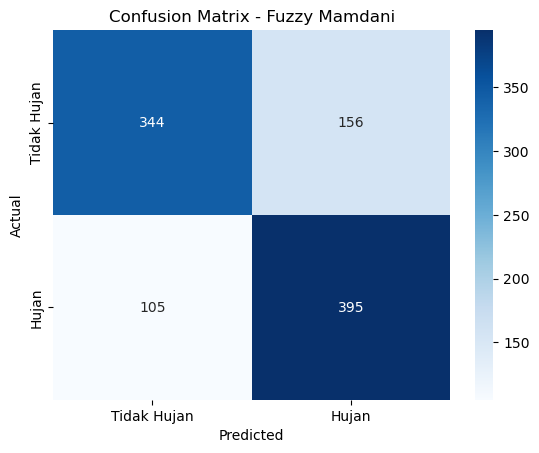


============ Evaluation for Fuzzy Sugeno ============
📌 Accuracy: 0.741

📌 Classification Report:
               precision    recall  f1-score   support

 Tidak Hujan       0.75      0.72      0.74       500
       Hujan       0.73      0.76      0.75       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



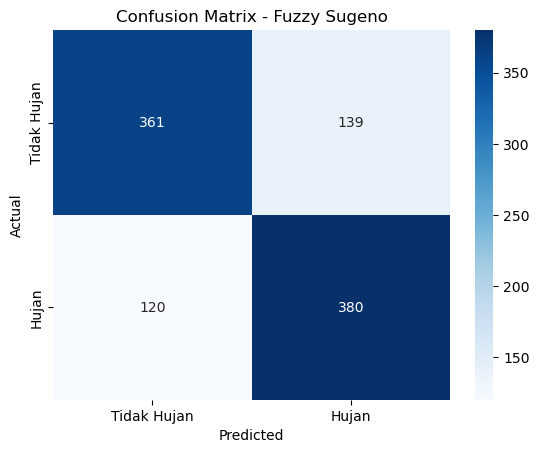

In [ ]:
# Evaluasi dengan scikit-learn
def evaluate_model(y_true, y_pred, method_name):
    print(f"\n============ Evaluation for {method_name} ============")
    print("📌 Accuracy:", accuracy_score(y_true, y_pred))
    print("\n📌 Classification Report:\n", classification_report(y_true, y_pred, target_names=["Tidak Hujan", "Hujan"]))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Tidak Hujan", "Hujan"], yticklabels=["Tidak Hujan", "Hujan"])
    plt.title(f'Confusion Matrix - {method_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def to_binary_label(value, threshold=0.5):
    return 1 if value >= threshold else 0

evaluate_model(y_true, mamdani_predictions, "Fuzzy Mamdani")
evaluate_model(y_true, sugeno_predictions, "Fuzzy Sugeno")